Bar 8/8
Bar 2/2
Bar 14/14
Centros de massa:
   CM_CR =  [ 0.43441642 -0.92316716]
   CM_C =  [ 0.74220436 -0.39704139]
   CM_F =  [ 1.92145361 -0.37803835]
Massas:
   M_CR =  77.5793238744298
   M_C =  4.8793238744298035
   M_F =  0.4604871113408232
Parametros do modelo:
   c =  0.06752172018689195
   w =  2.02
   lambda =  0.41887902047863906
Tensores de inercia:
I_CR:
[[ 8.82489307  0.          0.68280767]
 [ 0.         10.92178657  0.        ]
 [ 0.68280767  0.          2.0968935 ]]
I_F:
[[ 5.52329194e-03  0.00000000e+00 -1.48686086e-04]
 [ 0.00000000e+00  5.54662920e-03  0.00000000e+00]
 [-1.48686086e-04  0.00000000e+00  2.33372634e-05]]
I_Rt:
[[0.22652 0.      0.     ]
 [0.      0.45304 0.     ]
 [0.      0.      0.22652]]
I_Rd:
[[0.03825 0.      0.     ]
 [0.      0.0765  0.     ]
 [0.      0.      0.03825]]


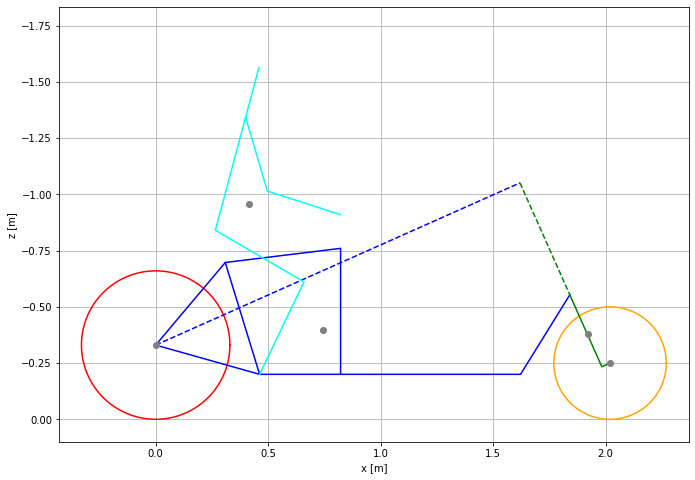

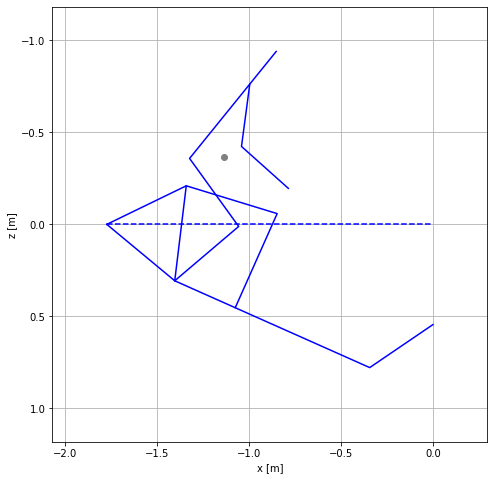

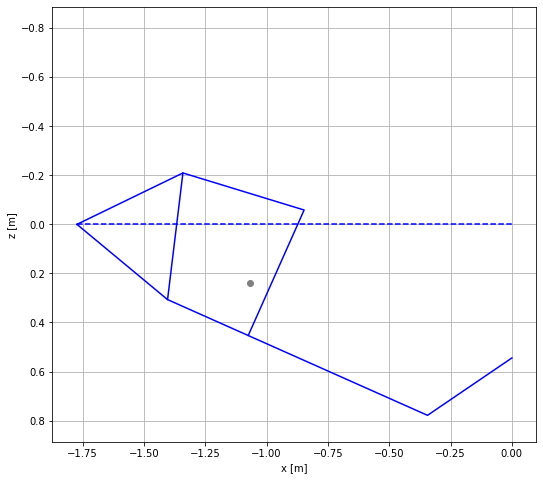

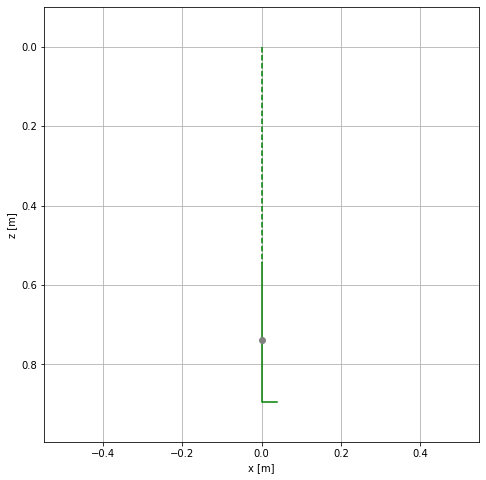

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, tan, sqrt, atan, pi, ceil

# FUNCOES AUXILIARES ===========================================================

# GEOMETRIA --------------------------------------------------------------------

def distance(p_1, p_2):
    # Calculates the distance between point p_1 and point p_2
    
    [x_1, z_1] = p_1
    [x_2, z_2] = p_2
    
    return sqrt((x_1 - x_2)**2 + (z_1 - z_2)**2)

def incline(p_1, p_2):
    # Calculates the slope between point p_1 and point p_2
    
    [x_1, z_1] = p_1
    [x_2, z_2] = p_2
    
    return atan((z_2 - z_1)/(x_2 - x_1))

def third_vertex(p_1, p_2, d_13, d_23):
    # Calculates the third vertex of a triangle, given the point p_1,
    # the point p_2, the distance d_13 between p_1 and the third vertex,
    # and the distance d_23 between p_2 and the third vertex
    
    [x_1, z_1] = p_1
    [x_2, z_2] = p_2
    
    d_12 = distance(p_1, p_2)
    
    c1 = (d_12**2 + d_13**2 - d_23**2)/(2*d_12)
    c2 = sqrt(d_13**2 - c1**2)
    
    return [x_1 + (c1*(x_2 - x_1) + c2*(z_1 - z_2))/d_12,
            z_1 + (c1*(z_2 - z_1) + c2*(x_2 - x_1))/d_12]

def rotate_points(P, theta):
    # Rotates the points P by theta relative to the origin
    
    R = np.array([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
    return np.dot(P, R)

# EQUACIONAMENTO ---------------------------------------------------------------

def parametrize(p_1, p_2):
    # Parametrizes the line between the point p_1 and the point p_2 into a
    # r(t) equation
    
    [x_1, z_1] = p_1
    [x_2, z_2] = p_2
    
    def r(t):
        return p_1 + np.array([x_2 - x_1, z_2 - z_1])*t
    
    return r

def quadratic_solver(a, b, c):
    # Solves a quadratic equation a*x^2 + b*x + c = 0 
    
    return (sqrt(b**2 - 4*a*c) - b)/(2*a)

# PROPRIEDADES FÍSICAS ---------------------------------------------------------

def pipe_area(r, e):
    # Calculates the transversal area of a pipe of radius r and thickness e
    
    return pi*(r**2 - (r - e)**2)

def frame_inertia(V, M, p_r, D, max_h):
    # Calculates the inertia of the vectors Vi, with respective mass Mi and
    # length Di, relative to the center of rotation p_r, with a step of max_h
    
    def point_inertia(p, p_r):
        # Calculates the inertia/m of a point p, relative to the center of
        # rotation p_r
    
        [x, z] = p
        [x_r, z_r] = p_r

        Ixx = (z - z_r)**2
        Izz = (x - x_r)**2
        Iyy = Ixx + Izz
        Ixz = -(x - x_r)*(z - z_r)

        I = np.array([[Ixx,   0, Ixz],
                      [  0, Iyy,   0],
                      [Ixz,   0, Izz]])

        return I
    
    I = np.array([[0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0]])
    
    n_V = len(V)
    for i in range(n_V):
        print('Bar %d/%d'%(i, n_V), end = '\r')
        n_h = int(ceil(D[i]/max_h))
        for j in range(n_h + 1):
            I += M[i]*point_inertia(V[i](j/n_h), p_r)/n_h
            
    print('Bar %d/%d'%(n_V, n_V))
            
    return I

def disk_inertia(m, r, e):
    # Calculates the inertia of a hollow disk of radius r, mass m and thickness
    
    Ixx = m*(r**2 + (r - e)**2)/4
    Iyy = 2*Ixx
    
    I = np.array([[Ixx,   0,   0],
                  [  0, Iyy,   0],
                  [  0,   0, Ixx]])
    
    return I

# GRAFICO ----------------------------------------------------------------------

def draw_circle(c, r, color):
    
    a = np.linspace(0, 2*pi, 100)
    x = r*np.cos(a) + c[0]
    z = r*np.sin(a) + c[1]
    plt.plot(x, z, color=color)
    
def draw_frame(N_C, N_e, color):
    
    dC_1 = np.vstack([N_C[0], N_C[1], N_C[2], N_C[0]]).transpose()
    dC_2 = np.vstack([N_C[1], N_C[3], N_C[4], N_C[2]]).transpose()
    dC_3 = np.vstack([N_C[3], N_C[5], N_C[6]]).transpose()
    dC_m = np.vstack([N_C[0], N_e]).transpose()
    
    plt.plot(dC_1[0], dC_1[1], color=color)
    plt.plot(dC_2[0], dC_2[1], color=color)
    plt.plot(dC_3[0], dC_3[1], color=color)
    plt.plot(dC_m[0], dC_m[1], '--', color=color)
    
def draw_fork(N_F, N_e, color):
    
    dF_1 = np.vstack([N_F[0], N_F[1], N_F[2]]).transpose()
    dF_m = np.vstack([N_e, N_F[0]]).transpose()
    
    plt.plot(dF_1[0], dF_1[1], color=color)
    plt.plot(dF_m[0], dF_m[1], '--', color=color)
    
def draw_rider(N_R, color):
    
    dR_1 = np.vstack(N_R[0:6]).transpose()
    dR_2 = np.vstack([N_R[3], N_R[6]]).transpose()
    
    plt.plot(dR_1[0], dR_1[1], color=color)
    plt.plot(dR_2[0], dR_2[1], color=color)
    
# PARAMETROS ======================================================================================================
    
r_t = 0.33 # Raio da roda traseira
r_d = 0.25 # Raio da roda dianteira
H_c = 0.2 # Distancia do frame até o chão
L_t = 2.6 # Comprimento horizontal total (inclui rodas)
L_F = L_t - r_t - r_d # Comprimento horizontal do frame ((1) até (9)) -> wheelbase

C_a = 24*pi/180 # 5.9931° para eixo reto -> steer axis tilt (lambda)

m_Rt = 2.6 + 3
m_Rd = 1.8

# Distancia entre pontos -> Medidas das barras --------------------------------------------------------------------
D = [0]*10
D[0] = 0.48 # Barra 1-2
D[1] = 0.48 # Barra 1-3
D[2] = 0.52 # Barra 2-3
D[3] = 0.36 # Barra 2-4
#    D[4]     Barra 3-5 -> calculado com (3) e (5)
D[5] = 0.56  # Barra 4-5
D[6] = 0.8  # Barra 4-6 -> espaço para carga
#    D[7]     Barra 6-7 -> calculado com C_a
D[8] = 0.35 # Barra 7-8
D[9] = 0.04 # Barra 8-9

p = 2.7e3 # densidade do material (Al6061)

# Area transversal das barras --------------------------------------------------
A = [0]*10
A[0] = pipe_area(0.0127, 0.008) # Barra 1-2
A[1] = pipe_area(0.0127, 0.008) # Barra 1-3
A[2] = pipe_area(0.0127, 0.008) # Barra 2-3
A[3] = pipe_area(0.0127, 0.008) # Barra 2-4
A[4] = pipe_area(0.0127, 0.008) # Barra 3-5
A[5] = pipe_area(0.0127, 0.008) # Barra 4-5
A[6] = pipe_area(0.0127, 0.008) # Barra 4-6
A[7] = pipe_area(0.0127, 0.008) # Barra 6-7
A[8] = pipe_area(0.0127, 0.008) # Barra 7-8
A[9] = pipe_area(0.0127, 0.008) # Barra 8-9

# NÓS ==========================================================================

N = np.zeros([9, 2]) # Nove nós no modelo --------------------------------------

# Roda traseira
N[0] = [0, r_t] # (1)

# Roda dianteira
N[8] = [L_F, r_d] # (9)

# Frame
N[1] = [sqrt(D[0]**2 - (r_t - H_c)**2), H_c]                  # (2)
N[2] = third_vertex(N[0], N[1], D[1], D[2])                   # (3)
N[3] = N[1] + [D[3], 0]                                       # (4)
N[4] = N[3] + [0, D[5]]                                       # (5)
N[5] = N[3] + [D[6], 0]                                       # (6)

d_79 = sqrt(D[8]**2 + D[9]**2)
a_879 = atan(D[9]/D[8])
N[6] = N[8] + [-d_79*sin(C_a + a_879), d_79*cos(C_a + a_879)] # (7)

D[4] = distance(N[2], N[4]) # Barra 3-5
D[7] = distance(N[5], N[6]) # Barra 6-7

# Fork
N[7] = third_vertex(N[8], N[6], D[9], D[8])

# Cálculo do nó do eixo representado no modelo ---------------------------------

# Frame
d_17 = distance(N[0], N[6])
d_18 = distance(N[0], N[7])

d_e7 = (d_18**2 - d_17**2 - D[8]**2)/(2*D[8])
C_d1 = sqrt(d_17**2 - d_e7**2)
N_e = third_vertex(N[0], N[7], C_d1, D[8] + d_e7)

# Fork
F_d2 = D[8] + d_e7
F_d3 = D[9]
F_a = C_a - pi/2

c = tan(C_a)*N_e[1] - (N[8, 0] - N_e[0]) # -> trail

# Nós dos corpos rigidos em seus respectivos sub-espaços -----------------------

# Frame
N_C = rotate_points(N[0:7] - N_e, -C_a)
N_Ce = [0, 0]

# Fork
N_F = rotate_points(N[6:9] - N_e, 3*pi/2 - F_a)
N_Fe = [0, 0]

# CICLISTA =====================================================================

d_s = 0.15  # Altura do assento
d_h = 0.15 # Altura do guidão

R_a = 75*pi/180 # Angulo de inclinação do ciclista

m_R = 72.7

# Para um brasileiro médio de 1.74m -> 7.5 cabeças
# 1 cabeça = 1.71/7.5 = 0.228
D_R = [0]*6
D_R[0] = 0.456 # 1-2 -> 2 cabeças
D_R[1] = 0.456 # 2-3 -> 2 cabeças
D_R[2] = 0.627 # 3-4 -> 2.75 cabeças
D_R[3] = 0.342 # 4-5 -> 1.5 cabeças
D_R[4] = 0.342 # 5-6 -> 1.5 cabeças
D_R[5] = 0.228 # 4-7 -> 1 cabeças

N_s = parametrize(N[2], N[1])(-d_s/D[2])
N_h = N[4] + [0, d_h]

N_R = np.zeros([7, 2]) # Sete nós no ciclista ----------------------------------
N_R[0] = N[1]
N_R[1] = third_vertex(N_s, N_R[0], D_R[0], D_R[1])
N_R[2] = N_s
N_R[3] = N_s + [D[2]*cos(R_a), D[2]*sin(R_a)]
N_R[4] = third_vertex(N_h, N_R[3], D_R[4], D_R[3])
N_R[5] = N_h
N_R[6] = N_R[3] + [D_R[5]*cos(R_a), D_R[5]*sin(R_a)]

# CONJUNTO FRAME + CICLISTA ====================================================

D_CR = D[0:8] + D_R

N_CR = rotate_points(np.vstack([N[0:7], N_R]) - N_e, -C_a)

# CORREÇÃO DOS NÓS NO EIXO Z ===================================================

N_e[1] *= -1
N[:, 1] *= -1
N_C[:, 1] *= -1
N_F[:, 1] *= -1

N_s[1] *= -1
N_h[1] *= -1
N_R[:, 1] *= -1

N_CR[:, 1] *= -1

# BARRAS =======================================================================

B_C = [None]*8 # Nós das oito barras do corpo C --------------------------------
B_C[0] = [N_C[0], N_C[1]] # Barra 1-2
B_C[1] = [N_C[0], N_C[2]] # Barra 1-3
B_C[2] = [N_C[1], N_C[2]] # Barra 2-3
B_C[3] = [N_C[1], N_C[3]] # Barra 2-4
B_C[4] = [N_C[2], N_C[4]] # Barra 3-5
B_C[5] = [N_C[3], N_C[4]] # Barra 4-5
B_C[6] = [N_C[3], N_C[5]] # Barra 4-6
B_C[7] = [N_C[5], N_C[6]] # Barra 6-7

B_F = [None]*2 # Nós das duas barras do corpo F --------------------------------
B_F[0] = [N_F[0], N_F[1]] # Barra 7-8
B_F[1] = [N_F[1], N_F[2]] # Barra 8-9

# Vetores r(t) representando as 10 barras --------------------------------------
V_C = [parametrize(b_C[0], b_C[1]) for b_C in B_C]
V_F = [parametrize(b_F[0], b_F[1]) for b_F in B_F]

# Massa das barras -------------------------------------------------------------

# Massas das barras -> A*D*p
M = [A[i]*D[i]*p for i in range(10)]

# Massas dos corpos rígidos
m_C = np.sum([M[0:8]])
m_F = np.sum([M[8:10]])

# BARRAS DO CICLISTA ===========================================================

B_R = [None]*6
B_R[0] = [N_R[0], N_R[1]] # 1-2
B_R[1] = [N_R[1], N_R[2]] # 2-3
B_R[2] = [N_R[2], N_R[3]] # 3-4
B_R[3] = [N_R[3], N_R[4]] # 4-5
B_R[4] = [N_R[4], N_R[5]] # 5-6
B_R[5] = [N_R[3], N_R[6]] # 4-7

V_R = [parametrize(b_R[0], b_R[1]) for b_R in B_R]

# Massas das barras do ciclista ------------------------------------------------

M_R = [0]*6
M_R[0] = 0.061*2*m_R # 1-2
M_R[1] = 0.100*2*m_R # 2-3
M_R[2] = 0.510*m_R   # 3-4
M_R[3] = 0.028*2*m_R # 4-5
M_R[4] = 0.022*2*m_R # 5-6
M_R[5] = 0.068*m_R   # 4-7

# CONJUNTO FRAME + CICLISTA ====================================================

B_CR = B_C + [None]*6
B_CR[8] = [N_CR[7], N_CR[8]] # 1-2
B_CR[9] = [N_CR[8], N_CR[9]] # 2-3
B_CR[10] = [N_CR[9], N_CR[10]] # 3-4
B_CR[11] = [N_CR[10], N_CR[11]] # 4-5
B_CR[12] = [N_CR[11], N_CR[12]] # 5-6
B_CR[13] = [N_CR[10], N_CR[13]] # 4-7

V_CR = [parametrize(b_CR[0], b_CR[1]) for b_CR in B_CR]

M_CR = M[0:8] + M_R
m_CR = m_C + m_R

# CENTRO DE MASSA ==============================================================

# Centro de massas (locais)
CM_C = np.sum([V_C[i](0.5)*M[i] for i in range(8)], axis=0)/m_C
CM_F = np.sum([V_F[i](0.5)*M[8 + i] for i in range(2)], axis=0)/m_F

CM_R = np.sum([V_R[i](0.5)*M_R[i] for i in range(6)], axis=0)/m_R

CM_CR = np.sum([V_CR[i](0.5)*M_CR[i] for i in range(14)], axis=0)/m_CR

# CM nas cordenadas globais
CM_Cg = (rotate_points([CM_C], -C_a) + N_e)[0]
CM_Fg = (rotate_points([CM_F], 3*pi/2 - F_a) + N_e)[0]

CM_CRg = (rotate_points([CM_CR], -C_a) + N_e)[0]

# CÁLCULO DA INERCIA (local) ===================================================

max_h = 1e-4

I_C = frame_inertia(V_C, M[0:8], CM_C, D[0:8], max_h)
I_F = frame_inertia(V_F, M[8:10], CM_F, D[8:10], max_h)

I_CR = frame_inertia(V_CR, M_CR, CM_CR, D_CR, max_h)

I_Rt = disk_inertia(m_Rt, r_t, 0.1) #2.6
I_Rd = disk_inertia(m_Rd, r_d, 0.1) # 1.8

# APRESENTAÇÃO DOS DADOS CALCULADOS ============================================

print('Centros de massa:')
print('   CM_CR = ', CM_CRg)
print('   CM_C = ', CM_Cg)
print('   CM_F = ', CM_Fg)
print('Massas:')
print('   M_CR = ', m_CR)
print('   M_C = ', m_C)
print('   M_F = ', m_F)
print('Parametros do modelo:')
print('   c = ', c)
print('   w = ', L_F)
print('   lambda = ', C_a)
print('Tensores de inercia:')
print('I_CR:')
print(I_CR)
print('I_F:')
print(I_F)
print('I_Rt:')
print(I_Rt)
print('I_Rd:')
print(I_Rd)

# PLOTAGEM =====================================================================

plt.figure(figsize=(16, 8))

draw_circle(N[0], r_t, 'red')
draw_circle(N[8], r_d, 'orange')

draw_frame(N[0:7], N_e, 'blue')
draw_fork(N[6:9], N_e, 'green')

draw_rider(N_R, 'cyan')

plt.plot(N[0, 0], N[0, 1], 'o', color='grey')
plt.plot(N[8, 0], N[8, 1], 'o', color='grey')

plt.plot(CM_Cg[0], CM_Cg[1], 'o', color='grey')
plt.plot(CM_Fg[0], CM_Fg[1], 'o', color='grey')

plt.plot(CM_R[0], CM_R[1], 'o', color='grey')

plt.xlim(-0.1 - r_t, L_F + r_d + 0.1)
plt.ylim(0.1, -(L_t/1.5 + 0.1))
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------

plt.figure(figsize=(16, 8))

draw_frame(N_CR[0:7], N_Ce, 'blue')
draw_rider(N_CR[7:14], 'blue')
plt.plot(CM_CR[0], CM_CR[1], 'o', color='grey')

plt.xlim(-(7*C_d1/6), C_d1/6)
plt.ylim(2*C_d1/3, -2*C_d1/3)
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------

plt.figure(figsize=(16, 8))

draw_frame(N_C, N_Ce, 'blue')
plt.plot(CM_C[0], CM_C[1], 'o', color='grey', label='CM')

plt.xlim(-(0.1 + C_d1), 0.1)
plt.ylim(C_d1/2, -C_d1/2)
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------

plt.figure(figsize=(16, 8))

draw_fork(N_F, N_Fe, 'green')
plt.plot(CM_F[0], CM_F[1], 'o', color='grey')

plt.xlim(-0.1 - F_d2/2, F_d2/2 + 0.1)
plt.ylim(F_d2 + 0.1, -0.1)
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()